<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

En este cuaderno vamos a probar todas las parejas posibles de métodos de fairness que afecten a distintas partes del proceso de la construcción del algoritmo de machine learning usando dos variables sensibles. Vamos a hacer un estudio de simulación.

# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

#Simulacion
from aif360.datasets import BinaryLabelDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Selección de dataset.

El siguiente bloque permite seleccionar el conjunto de datos sobre el que trabajar. Debe recordarse que el conjunto de `homecredit` es mucho mayor por lo que tardará más tiempo en ejecutarse.


In [3]:
def logit(x):
    return np.log(x/(1-x))

def inv_logit(x):
    return np.exp(x)/(1+np.exp(x))

def simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma):
    
    p = n_var + n_sens
    coef = np.concatenate((gamma, beta))
        
    X = np.random.multivariate_normal(mean_vec, cov, size = n_obs)
    probs_var = inv_logit(X)
    bin = np.random.binomial(1, probs_var)
    
    probs_Y = inv_logit(coef.dot(X.T))
    Y = np.random.binomial(1, probs_Y)
    
    names = ['0' for i in range(p+1)]
    sens = ['0' for i in range(n_sens)]
    var = 1
    
    names[0] = 'response'
    
    for i in range(1,p+1):
        if i-1 < n_sens:
            sens[i-1] = 'sens ' + str(i)
            names[i] = 'sens ' + str(i)
        if i-1 >= n_sens:
            names[i] = 'var ' + str(var)
            var += 1
    
    names = np.array(names)
    sens = np.array(sens)
    response = np.array(['response'])
    
    Y = Y.reshape((n_obs,1))
    
    bin = np.concatenate((Y, bin), axis = 1)
    
    data_pd = pd.DataFrame(bin, columns = names)
    data = BinaryLabelDataset(df = data_pd, favorable_label = 1, unfavorable_label = 0, label_names = response, protected_attribute_names = sens)
    return data

In [4]:
n_obs = 1000
n_var = 30
n_sens = 2
mean_vec = np.zeros(n_var+n_sens)
cov = np.identity(n_var+n_sens)
beta = np.zeros(n_var)
gamma = np.ones(n_sens)

dataset1 = simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma)

#dataset.favorable_label = 1
#dataset.unfavorable_label = 0

new_data = dataset1.convert_to_dataframe()[0]

sens1 = new_data.loc[:,'sens 1']
sens2 = new_data.loc[:,'sens 2']
new_sens = sens1.copy()
new_sens[sens2 == 1] = 1

new_data = new_data.drop(['sens 1', 'sens 2'], axis = 1)
new_data['sens 1'] = new_sens

names = np.array(new_data.columns)
sens = np.array(['sens 1'])
response = np.array(['response'])

dataset = BinaryLabelDataset(df = new_data,
                             favorable_label = 1,
                             unfavorable_label = 0,
                             label_names = response,
                             protected_attribute_names = sens)

# Separamos el conjunto de datos en train, validate, test
data_train, vt = dataset.split([0.7], shuffle=True, seed=seed)
data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

data_train2, vt2 = dataset1.split([0.7], shuffle=True, seed=seed)
data_val2, data_test2 = vt2.split([0.5], shuffle=True, seed=seed)

# Obtenemos los indicadores del grupo sensible
sensitive_attribute = dataset.protected_attribute_names[0]
privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset)
    
print(f'Dimensiones del conjunto de datos: {dataset.features.shape}')
print("Grupos privilegiados:", privileged_groups)
print("Grupos no privilegiados:", unprivileged_groups)
print("Label del grupo favorable:", dataset.favorable_label)
print("Label del grupo desfavorable:", dataset.unfavorable_label)

Dimensiones del conjunto de datos: (1000, 31)
Grupos privilegiados: [{'sens 1': 1.0}]
Grupos no privilegiados: [{'sens 1': 0.0}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [5]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [6]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 10.5 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5581
Balanced accuracy: 0.5857
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.3222
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1165
Sufficiency ( |ΔPPV| ) : 0.0078
CPU times: user 162 ms, sys: 17.4 ms, total: 179 ms
Wall time: 162 ms


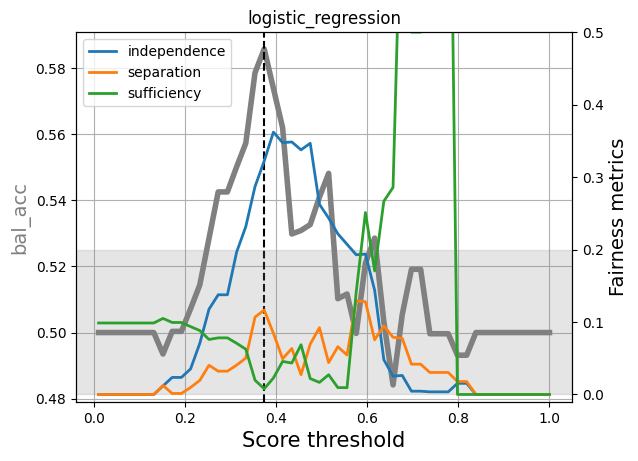

In [7]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [8]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5041
Balanced accuracy: 0.5360
Accuracy: 0.5600
Independence ( |ΔP(Y_pred = 1)| ): 0.2834
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0670
Sufficiency ( |ΔPPV| ) : 0.0383


### XGBoost

In [9]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 32.8 s, sys: 152 ms, total: 32.9 s
Wall time: 578 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5296
Balanced accuracy: 0.5633
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.1701
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0839
Sufficiency ( |ΔPPV| ) : 0.0213
CPU times: user 2.42 s, sys: 23.6 ms, total: 2.44 s
Wall time: 164 ms


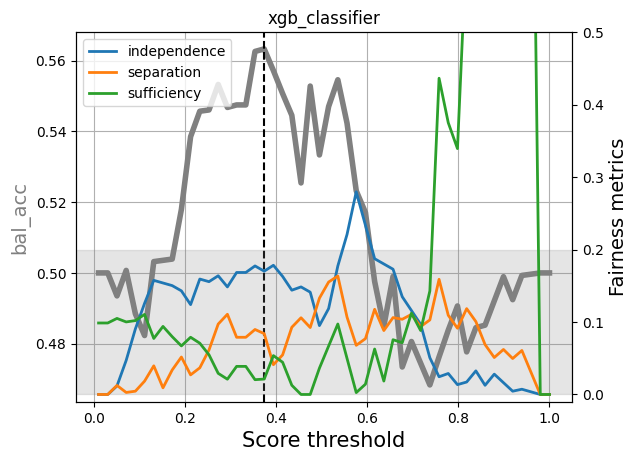

In [10]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [11]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5230
Balanced accuracy: 0.5375
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.2292
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0328
Sufficiency ( |ΔPPV| ) : 0.0565


## Técnicas de preprocesado

### Reponderación

In [12]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups, 
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_REW = PreProcessor.transform(data_train_copy)
data_val_REW = PreProcessor.transform(data_val_copy)
data_test_REW = PreProcessor.transform(data_test_copy)

CPU times: user 14.8 ms, sys: 667 µs, total: 15.5 ms
Wall time: 14 ms


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

### Eliminador de impacto dispar

In [13]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_DIR = PreProcessor.fit_transform(data_train_copy)
data_val_DIR = PreProcessor.fit_transform(data_val_copy)
data_test_DIR = PreProcessor.fit_transform(data_test_copy)



CPU times: user 205 ms, sys: 3.32 ms, total: 209 ms
Wall time: 208 ms


## Entrenamiento de técnicas de inprocesado

Entrenamos ahora los algoritmos de inprocesado para aplicarlos posteriormente cuando hagan falta.

### Eliminador de prejuicios por regularización

In [14]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [15]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [16]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )
    models[model_name_quality].scores_train = models[model_name_quality].predict(data_train_copy).scores
    models[model_name_quality].scores_val = models[model_name_quality].predict(data_val_copy).scores
    models[model_name_quality].scores_test = models[model_name_quality].predict(data_test_copy).scores

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [17]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep_mult(
        dataset=data_val_copy,
        dataset2=data_val2_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics_mult(
        dataset=data_test_copy, 
        dataset2=data_test2_copy,
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Eliminación de prejuicios adversarios

In [18]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

2024-06-19 10:02:01.033598: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-19 10:02:01.451619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.749041; batch adversarial loss: 0.639364
epoch 1; iter: 0; batch classifier loss: 0.715875; batch adversarial loss: 0.619905
epoch 2; iter: 0; batch classifier loss: 0.716384; batch adversarial loss: 0.669102
epoch 3; iter: 0; batch classifier loss: 0.686084; batch adversarial loss: 0.623451
epoch 4; iter: 0; batch classifier loss: 0.717599; batch adversarial loss: 0.619547
epoch 5; iter: 0; batch classifier loss: 0.699333; batch adversarial loss: 0.652642
epoch 6; iter: 0; batch classifier loss: 0.700948; batch adversarial loss: 0.609697
epoch 7; iter: 0; batch classifier loss: 0.687184; batch adversarial loss: 0.626084
epoch 8; iter: 0; batch classifier loss: 0.742980; batch adversarial loss: 0.680710
epoch 9; iter: 0; batch classifier loss: 0.692420; batch adversarial loss: 0.634461
epoch 10; iter: 0; batch classifier loss: 0.713012; batch adversarial loss: 0.676387
epoch 11; iter: 0; batch classifier loss: 0.695930; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.1312
AUC: 0.4165
Balanced accuracy: 0.5223
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.0371
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0114
Sufficiency ( |ΔPPV| ) : 0.1052
CPU times: user 250 ms, sys: 350 ms, total: 600 ms
Wall time: 174 ms


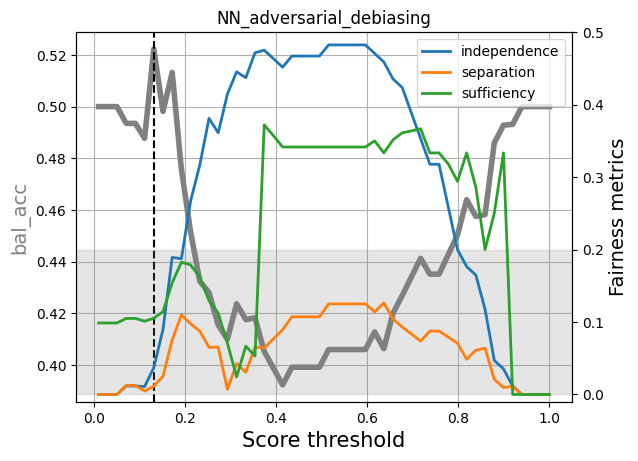

In [19]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [20]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

epoch 0; iter: 0; batch classifier loss: 0.700894
epoch 1; iter: 0; batch classifier loss: 0.681757
epoch 2; iter: 0; batch classifier loss: 0.657793
epoch 3; iter: 0; batch classifier loss: 0.673350
epoch 4; iter: 0; batch classifier loss: 0.676446
epoch 5; iter: 0; batch classifier loss: 0.673696
epoch 6; iter: 0; batch classifier loss: 0.623330
epoch 7; iter: 0; batch classifier loss: 0.654766
epoch 8; iter: 0; batch classifier loss: 0.626738
epoch 9; iter: 0; batch classifier loss: 0.655193
epoch 10; iter: 0; batch classifier loss: 0.675038
epoch 11; iter: 0; batch classifier loss: 0.690360
epoch 12; iter: 0; batch classifier loss: 0.633009
epoch 13; iter: 0; batch classifier loss: 0.610069
epoch 14; iter: 0; batch classifier loss: 0.624916
epoch 15; iter: 0; batch classifier loss: 0.633191
epoch 16; iter: 0; batch classifier loss: 0.641241
epoch 17; iter: 0; batch classifier loss: 0.674421
epoch 18; iter: 0; batch classifier loss: 0.652796
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5690
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.2208
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0660
Sufficiency ( |ΔPPV| ) : 0.1386
CPU times: user 174 ms, sys: 11 ms, total: 185 ms
Wall time: 165 ms


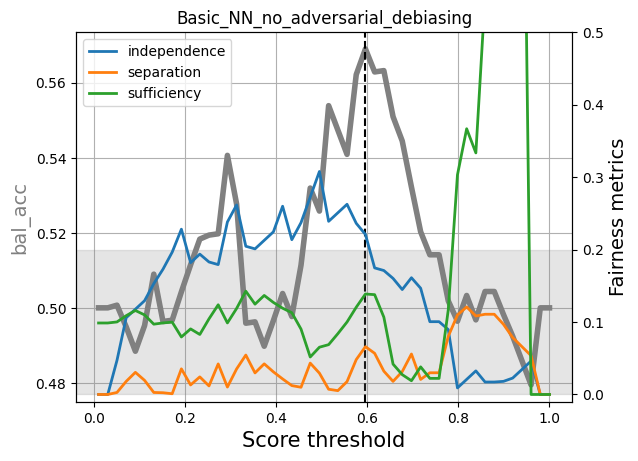

In [21]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Inprocesado

### Reponderación + Eliminador de prejuicios

In [22]:
# Nombre del modelo
model_name = 'reweighting_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + Eliminador de prejuicios

In [ ]:
# Nombre del modelo
model_name = 'disparate_impact_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + metafairness

In [23]:
%%time 
# Nombramos al modelo
model_name = 'reweighing_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
    data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [24]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep_mult(
        dataset=data_val_copy,
        dataset2=data_val2_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics_mult(
        dataset=data_test_copy, 
        dataset2=data_test2_copy,
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for reweighing_meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Impacto dispar + metafairness

In [25]:
%%time 
# Nombramos al modelo
model_name = 'disparate_impact_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
    data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

TypeError: cannot unpack non-iterable NoneType object

In [26]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep_mult(
        dataset=data_val_copy,
        dataset2=data_val2_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics_mult(
        dataset=data_test_copy, 
        dataset2=data_test2_copy,
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for disparate_impact_meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Reponderación + prejuicios adversarios

In [27]:
%%time

# Nombramos al modelo
model_name = 'reweighing_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.715623; batch adversarial loss: 0.770134
epoch 1; iter: 0; batch classifier loss: 0.718078; batch adversarial loss: 0.845650
epoch 2; iter: 0; batch classifier loss: 0.703984; batch adversarial loss: 0.791471
epoch 3; iter: 0; batch classifier loss: 0.721734; batch adversarial loss: 0.872058
epoch 4; iter: 0; batch classifier loss: 0.719997; batch adversarial loss: 0.848077
epoch 5; iter: 0; batch classifier loss: 0.732676; batch adversarial loss: 0.855093
epoch 6; iter: 0; batch classifier loss: 0.654529; batch adversarial loss: 0.791269
epoch 7; iter: 0; batch classifier loss: 0.717592; batch adversarial loss: 0.860092
epoch 8; iter: 0; batch classifier loss: 0.725713; batch adversarial loss: 0.877899
epoch 9; iter: 0; batch classifier loss: 0.717247; batch adversarial loss: 0.845587
epoch 10; iter: 0; batch classifier loss: 0.642822; batch adversarial loss: 0.826816
epoch 11; iter: 0; batch classifier loss: 0.688717; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.5748
Balanced accuracy: 0.5839
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.4769
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0771
Sufficiency ( |ΔPPV| ) : 0.0093
CPU times: user 273 ms, sys: 301 ms, total: 574 ms
Wall time: 193 ms


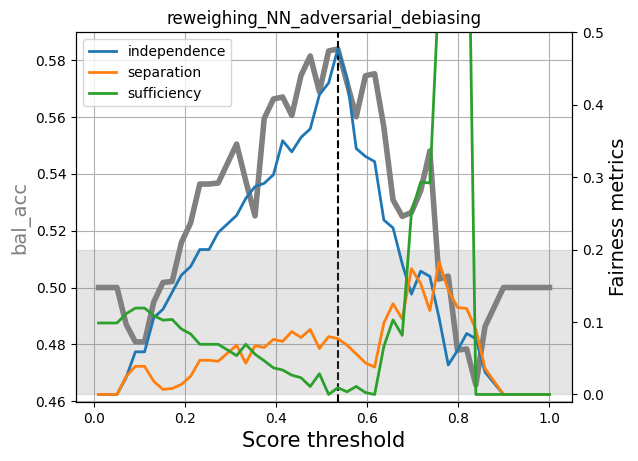

In [28]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + red neuronal normal

In [29]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'reweighin_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.759173
epoch 1; iter: 0; batch classifier loss: 0.716929
epoch 2; iter: 0; batch classifier loss: 0.695602
epoch 3; iter: 0; batch classifier loss: 0.694925
epoch 4; iter: 0; batch classifier loss: 0.695898
epoch 5; iter: 0; batch classifier loss: 0.667745
epoch 6; iter: 0; batch classifier loss: 0.693482
epoch 7; iter: 0; batch classifier loss: 0.677569
epoch 8; iter: 0; batch classifier loss: 0.676190
epoch 9; iter: 0; batch classifier loss: 0.640076
epoch 10; iter: 0; batch classifier loss: 0.683027
epoch 11; iter: 0; batch classifier loss: 0.643261
epoch 12; iter: 0; batch classifier loss: 0.634701
epoch 13; iter: 0; batch classifier loss: 0.641942
epoch 14; iter: 0; batch classifier loss: 0.633727
epoch 15; iter: 0; batch classifier loss: 0.642284
epoch 16; iter: 0; batch classifier loss: 0.641237
epoch 17; iter: 0; batch classifier loss: 0.648390
epoch 18; iter: 0; batch classifier loss: 0.623454
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.6161
AUC: 0.5332
Balanced accuracy: 0.5636
Accuracy: 0.5600
Independence ( |ΔP(Y_pred = 1)| ): 0.1674
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0474
Sufficiency ( |ΔPPV| ) : 0.0000
CPU times: user 187 ms, sys: 17.6 ms, total: 205 ms
Wall time: 184 ms


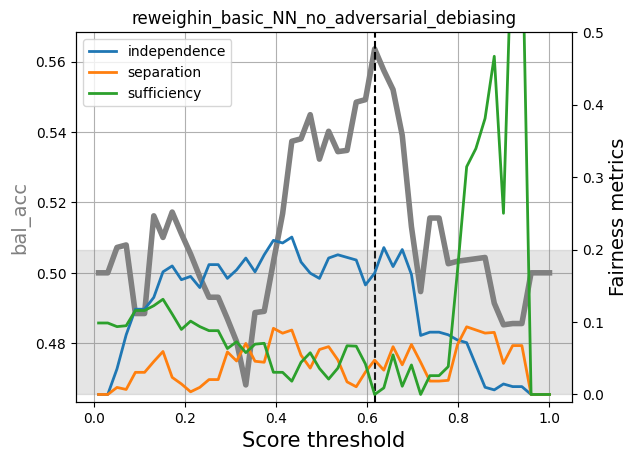

In [30]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + eliminación de prejuicios adversarios

In [31]:
%%time

# Nombramos al modelo
model_name = 'disparate_impact_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.697606; batch adversarial loss: 0.599260
epoch 1; iter: 0; batch classifier loss: 0.703866; batch adversarial loss: 0.605878
epoch 2; iter: 0; batch classifier loss: 0.741059; batch adversarial loss: 0.609282
epoch 3; iter: 0; batch classifier loss: 0.682985; batch adversarial loss: 0.634859
epoch 4; iter: 0; batch classifier loss: 0.746601; batch adversarial loss: 0.637346
epoch 5; iter: 0; batch classifier loss: 0.723819; batch adversarial loss: 0.635786
epoch 6; iter: 0; batch classifier loss: 0.693556; batch adversarial loss: 0.620487
epoch 7; iter: 0; batch classifier loss: 0.716176; batch adversarial loss: 0.656753
epoch 8; iter: 0; batch classifier loss: 0.668129; batch adversarial loss: 0.624644
epoch 9; iter: 0; batch classifier loss: 0.668137; batch adversarial loss: 0.627934
epoch 10; iter: 0; batch classifier loss: 0.671664; batch adversarial loss: 0.656045
epoch 11; iter: 0; batch classifier loss: 0.700296; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.6767
AUC: 0.4332
Balanced accuracy: 0.5116
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.0362
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0625
Sufficiency ( |ΔPPV| ) : 0.3810
CPU times: user 436 ms, sys: 61.8 ms, total: 498 ms
Wall time: 477 ms


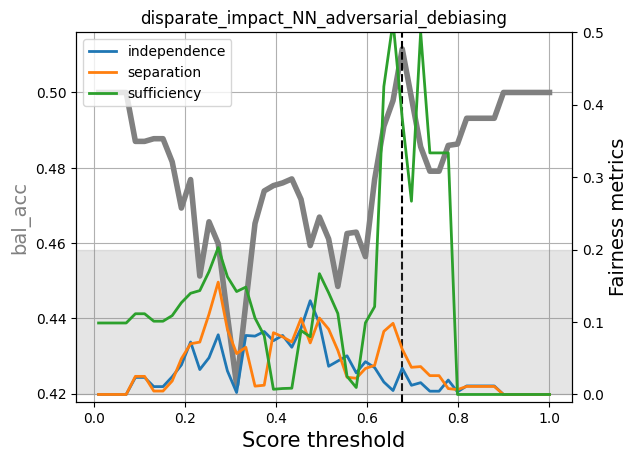

In [32]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + red neuronal normal

In [33]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'disparate_impact_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.708635
epoch 1; iter: 0; batch classifier loss: 0.681923
epoch 2; iter: 0; batch classifier loss: 0.675400
epoch 3; iter: 0; batch classifier loss: 0.681979
epoch 4; iter: 0; batch classifier loss: 0.660948
epoch 5; iter: 0; batch classifier loss: 0.644093
epoch 6; iter: 0; batch classifier loss: 0.669532
epoch 7; iter: 0; batch classifier loss: 0.653826
epoch 8; iter: 0; batch classifier loss: 0.658202
epoch 9; iter: 0; batch classifier loss: 0.634188
epoch 10; iter: 0; batch classifier loss: 0.657329
epoch 11; iter: 0; batch classifier loss: 0.659480
epoch 12; iter: 0; batch classifier loss: 0.651900
epoch 13; iter: 0; batch classifier loss: 0.641663
epoch 14; iter: 0; batch classifier loss: 0.643005
epoch 15; iter: 0; batch classifier loss: 0.646749
epoch 16; iter: 0; batch classifier loss: 0.620220
epoch 17; iter: 0; batch classifier loss: 0.628326
epoch 18; iter: 0; batch classifier loss: 0.629691
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.6161
AUC: 0.5568
Balanced accuracy: 0.5762
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.2018
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0042
Sufficiency ( |ΔPPV| ) : 0.0594
CPU times: user 185 ms, sys: 21.9 ms, total: 207 ms
Wall time: 188 ms


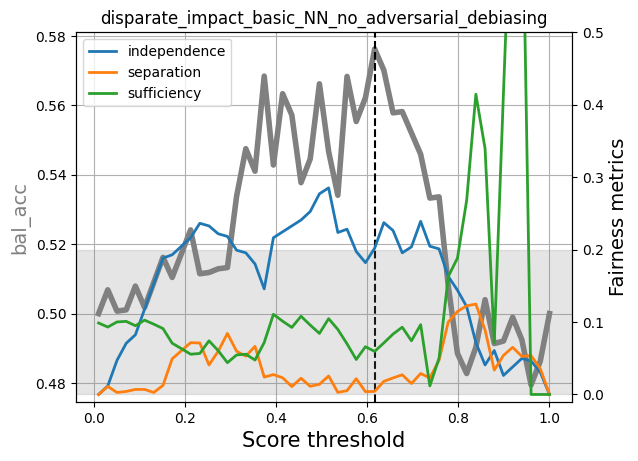

In [34]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Postprocesado

### Entrenamiento de modelos con técnicas de preprocesado

#### Reponderación

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.4764
Balanced accuracy: 0.5199
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0416
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1002
Sufficiency ( |ΔPPV| ) : 0.1000


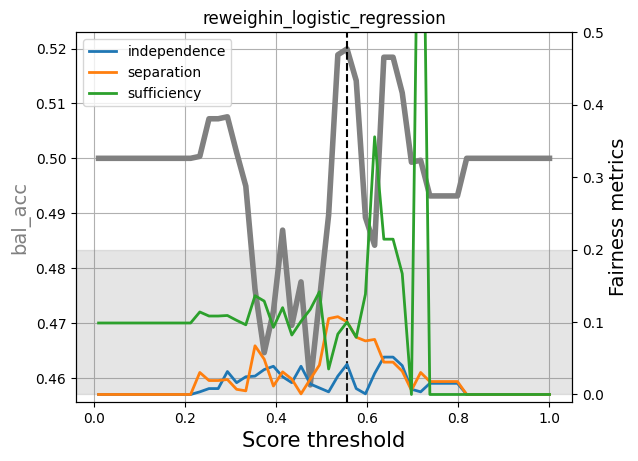

In [35]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Regresión logística
model_name = 'reweighin_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5296
Balanced accuracy: 0.5633
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.1701
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0839
Sufficiency ( |ΔPPV| ) : 0.0213
CPU times: user 32.1 s, sys: 194 ms, total: 32.3 s
Wall time: 646 ms


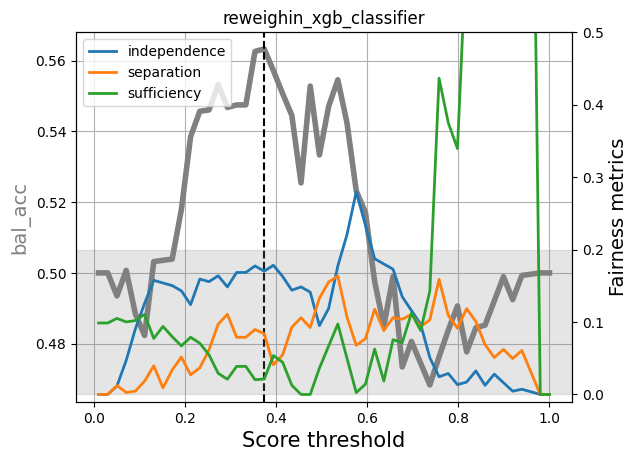

In [36]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'reweighin_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

#### Disparate impact

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5581
Balanced accuracy: 0.5857
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.3222
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1165
Sufficiency ( |ΔPPV| ) : 0.0078


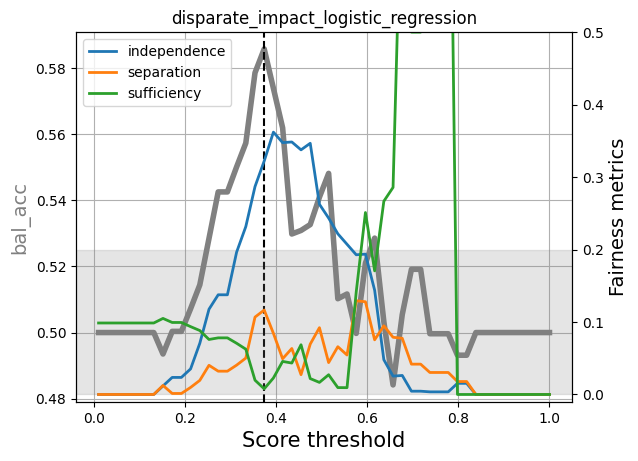

In [37]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Regresión logística
model_name = 'disparate_impact_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5296
Balanced accuracy: 0.5633
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.1701
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0839
Sufficiency ( |ΔPPV| ) : 0.0213
CPU times: user 33.3 s, sys: 153 ms, total: 33.5 s
Wall time: 668 ms


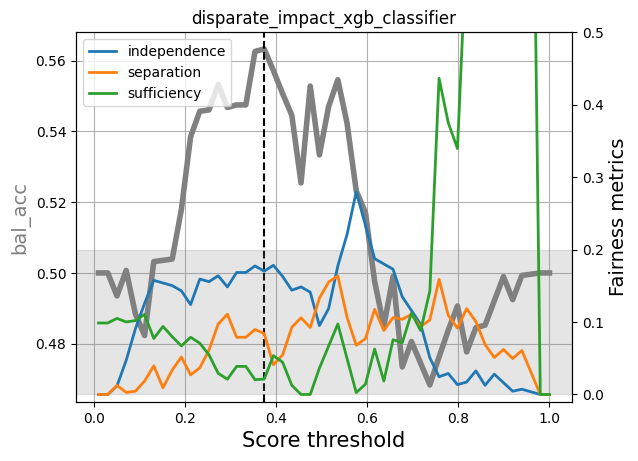

In [38]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'disparate_impact_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [39]:
#Anotamos los nombres de los modelos
model_names = ['reweighin_logistic_regression', 'reweighin_xgb_classifier', 'disparate_impact_logistic_regression', 'disparate_impact_xgb_classifier']

### Aplicación de técnicas de postprocesado 

#### Reponderación + Clasificación de rechazo de opción

In [40]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 10.5 s, sys: 3.31 s, total: 13.8 s
Wall time: 9.84 s


In [41]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

reweighin_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5346
AUC: 0.4764
Balanced accuracy: 0.5322
Accuracy: 0.5267
Independence ( |ΔP(Y_pred = 1)| ): 0.0009
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0937
Sufficiency ( |ΔPPV| ) : 0.0938


reweighin_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.5346
AUC: 0.4764
Balanced accuracy: 0.5120
Accuracy: 0.5067
Independence ( |ΔP(Y_pred = 1)| ): 0.0772
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1091
Sufficiency ( |ΔPPV| ) : 0.0429


reweighin_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.4951
AUC: 0.4764
Balanced accuracy: 0.4742
Accuracy: 0.4733
Independence ( |ΔP(Y_pred = 1)| ): 0.0627
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0156
Sufficiency ( |ΔPPV| ) : 0.2177




In [42]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 11.1 s, sys: 153 ms, total: 11.3 s
Wall time: 9.65 s


In [43]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

reweighin_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.1684
AUC: 0.5296
Balanced accuracy: 0.5039
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.1002
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1330
Sufficiency ( |ΔPPV| ) : 0.3125


reweighin_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5252
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.2710
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1118
Sufficiency ( |ΔPPV| ) : 0.3137


reweighin_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5252
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.2710
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1118
Sufficiency ( |ΔPPV| ) : 0.3137




#### Impacto dispar + Rechazo de opción

In [44]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.94 s, sys: 3.42 s, total: 13.4 s
Wall time: 9.32 s


In [45]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

disparate_impact_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.4852
AUC: 0.5581
Balanced accuracy: 0.5257
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.0253
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1310
Sufficiency ( |ΔPPV| ) : 0.0170


disparate_impact_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.4654
AUC: 0.5581
Balanced accuracy: 0.4965
Accuracy: 0.4933
Independence ( |ΔP(Y_pred = 1)| ): 0.0195
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1446
Sufficiency ( |ΔPPV| ) : 0.0571


disparate_impact_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.4852
AUC: 0.5581
Balanced accuracy: 0.5189
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0680
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0982
Sufficiency ( |ΔPPV| ) : 0.0588




In [46]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 10.8 s, sys: 196 ms, total: 11 s
Wall time: 9.51 s


In [47]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

disparate_impact_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.1684
AUC: 0.5296
Balanced accuracy: 0.5039
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.1002
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1330
Sufficiency ( |ΔPPV| ) : 0.3125


disparate_impact_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5252
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.2710
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1118
Sufficiency ( |ΔPPV| ) : 0.3137


disparate_impact_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5252
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.2710
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1118
Sufficiency ( |ΔPPV| ) : 0.3137




#### Reponderación y impacto dispar + Escalado de Platt por grupos

In [48]:
%%time
fairness_method = '_platt_scaling'
model_names = model_names
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name], class_thresh = model_thresh)
    data_val_preds_m = utils.update_dataset_from_model2(data_val, data_val2_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2_m = data_val_preds_m.copy(deepcopy = True)
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        data_val_preds2_m.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores_mult(
            dataset_true = data_val_copy,
            dataset2 =data_val2_copy,
            dataset_preds = data_val_preds2_m,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for reweighin_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.5582
AUC: 0.6250
Balanced accuracy: 0.6009
Accuracy: 0.6067
Independence ( |ΔP(Y_pred = 1)| ): 0.4670
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1071
Sufficiency ( |ΔPPV| ) : 0.0128

Validation set results for reweighin_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.5644
AUC: 0.6239
Balanced accuracy: 0.6192
Accuracy: 0.6200
Independence ( |ΔP(Y_pred = 1)| ): 0.3620
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0327
Sufficiency ( |ΔPPV| ) : 0.0000

Validation set results for disparate_impact_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.5701
AUC: 0.6248
Balanced accuracy: 0.6099
Accuracy: 0.6133
Independence ( |ΔP(Y_pred = 1)| ): 0.4570
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0461
Sufficiency ( |ΔPPV| ) : 0.0089

Validation set results for disparate_impact_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.5644
AUC: 0.6239
Balanced

In [49]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    data_test_preds_m = utils.update_dataset_from_model2(data_test_copy, data_test2_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    data_test_preds2_m = data_test_preds_m.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)

    data_test_preds2_m = data_test2_copy.copy(deepcopy = True)
    data_test_preds2_m.scores = data_test_preds2.scores
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores_mult(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2_m,
                                                                                             dataset2=data_test2_copy,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Reponderación + Procesador de probabilidades igualadas

##### Usando labels

In [50]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [51]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset2=data_test2_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [52]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [53]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [54]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 267 ms, sys: 860 ms, total: 1.13 s
Wall time: 39.8 ms


In [55]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for reweighin_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.4764
Balanced accuracy: 0.5199
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0130
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0894
Sufficiency ( |ΔPPV| ) : 0.0714


Results for reweighin_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.4764
Balanced accuracy: 0.5199
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0130
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0894
Sufficiency ( |ΔPPV| ) : 0.0714


Results for reweighin_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.4764
Balanced accuracy: 0.5199
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0130
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0894
Sufficiency ( |ΔPPV| ) : 0.0714




In [56]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 3.93 s, sys: 101 ms, total: 4.03 s
Wall time: 77.6 ms


In [57]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset2=data_test2_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for reweighin_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5296
Balanced accuracy: 0.5770
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.5084
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0016
Sufficiency ( |ΔPPV| ) : 0.1976


Results for reweighin_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.5296
Balanced accuracy: 0.5608
Accuracy: 0.5600
Independence ( |ΔP(Y_pred = 1)| ): 0.4164
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0871
Sufficiency ( |ΔPPV| ) : 0.0067


Results for reweighin_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5296
Balanced accuracy: 0.5907
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.5572
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0386
Sufficiency ( |ΔPPV| ) : 0.0976




#### Impacto dispar + Procesador de probabilidades igualadas

##### Usando labels

In [58]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [59]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset2=data_test2_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [60]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [61]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset2=data_test2_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

##### Usando scores

In [62]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 230 ms, sys: 490 ms, total: 721 ms
Wall time: 28.4 ms


In [63]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset2=data_test2_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for disparate_impact_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5581
Balanced accuracy: 0.6012
Accuracy: 0.6067
Independence ( |ΔP(Y_pred = 1)| ): 0.9725
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0138
Sufficiency ( |ΔPPV| ) : 0.5849


Results for disparate_impact_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.5581
Balanced accuracy: 0.5937
Accuracy: 0.6000
Independence ( |ΔP(Y_pred = 1)| ): 0.9512
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0172
Sufficiency ( |ΔPPV| ) : 0.0780


Results for disparate_impact_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5581
Balanced accuracy: 0.6012
Accuracy: 0.6067
Independence ( |ΔP(Y_pred = 1)| ): 0.9725
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0138
Sufficiency ( |ΔPPV| ) : 0.5849




In [64]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 3.9 s, sys: 75.5 ms, total: 3.98 s
Wall time: 77.9 ms


In [65]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for disparate_impact_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5296
Balanced accuracy: 0.5770
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.5084
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0016
Sufficiency ( |ΔPPV| ) : 0.1976


Results for disparate_impact_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.5296
Balanced accuracy: 0.5608
Accuracy: 0.5600
Independence ( |ΔP(Y_pred = 1)| ): 0.4164
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0871
Sufficiency ( |ΔPPV| ) : 0.0067


Results for disparate_impact_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.5296
Balanced accuracy: 0.5907
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.5572
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0386
Sufficiency ( |ΔPPV| ) : 0.0976




## Inprocesado + Postprocesado

In [66]:
#Anotamos los nombres de los modelos que vamos a usar
model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']

### Eliminador de prejuicios + rechazo de opción

In [67]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

In [68]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

KeyError: 'prejudice_remover_reject_option_spd'

### Metafairness + rechazo de opción

In [69]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.99 s, sys: 217 ms, total: 10.2 s
Wall time: 10.2 s


In [70]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_sr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.1684
AUC: 0.5296
Balanced accuracy: 0.5039
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.1002
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1330
Sufficiency ( |ΔPPV| ) : 0.3125


meta_fairness_sr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5252
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.2710
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1118
Sufficiency ( |ΔPPV| ) : 0.3137


meta_fairness_sr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5252
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.2710
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1118
Sufficiency ( |ΔPPV| ) : 0.3137




### Prejuicios adversarios + rechazo de opción

In [71]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.62 s, sys: 176 ms, total: 9.79 s
Wall time: 9.79 s


In [72]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        dataset2=data_val2_copy,
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset2=data_test2_copy,
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_fdr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.1684
AUC: 0.5296
Balanced accuracy: 0.5402
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1068
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1440
Sufficiency ( |ΔPPV| ) : 0.0512


meta_fairness_fdr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5402
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1068
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1440
Sufficiency ( |ΔPPV| ) : 0.0512


meta_fairness_fdr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5402
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1068
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1440
Sufficiency ( |ΔPPV| ) : 0.0512




### Red neuronal normal + rechazo de opción

In [73]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.69 s, sys: 229 ms, total: 9.92 s
Wall time: 9.92 s


In [74]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        dataset2=data_val2_copy,
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

NN_adversarial_debiasing_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.1684
AUC: 0.5296
Balanced accuracy: 0.5402
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1068
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1440
Sufficiency ( |ΔPPV| ) : 0.0512


NN_adversarial_debiasing_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5402
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1068
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1440
Sufficiency ( |ΔPPV| ) : 0.0512


NN_adversarial_debiasing_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5296
Balanced accuracy: 0.5402
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1068
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1440
Sufficiency ( |ΔPPV| ) : 0.0512




### Inprocesado + Escalado Platt por grupos

In [75]:
%%time
fairness_method = '_platt_scaling'

model_names = ['NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['meta_fairness_fdr', 'meta_fairness_sr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                            'unpriv': [data_val_preds_unpriv, unpriv_indices]}
    
    for group, data_group_list in sensitive_groups_data.items():
    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)
    
        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()
    
        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                      data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
            
        # Evaluamos a los modelos para el rango de umbrales
        thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                         np.max(data_val_preds2.scores.ravel()),
                                         50)
        data_val_preds2_m = data_val2_copy.copy(deepcopy = True)
        data_val_preds2_m.scores = data_val_preds2.scores
        metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores_mult(
                dataset_true = data_val_copy,
                dataset2=data_val2_copy,
                dataset_preds = data_val_preds2_m,
                thresh_arr = thresh_sweep_platt
            )
    
        # Evaluamos las métricas para el mejor umbral y las guardamos
        metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )
    
        # Graficamos el comportamiento del modelo para el rango de umbrales 
        print('\nValidation set results for {}'.format(model_name))
        utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
        # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
        # plt.title( model_name+fairness_method )
        
        f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
        a.set_title(model_name+fairness_method )
        f


Validation set results for NN_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.9257
AUC: 0.4165
Balanced accuracy: 0.5000
Accuracy: 0.4867
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0000

Validation set results for NN_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.3445
AUC: 0.6099
Balanced accuracy: 0.5940
Accuracy: 0.6000
Independence ( |ΔP(Y_pred = 1)| ): 0.4824
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1250
Sufficiency ( |ΔPPV| ) : 0.0217

Validation set results for Basic_NN_no_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5145
AUC: 0.5545
Balanced accuracy: 0.5728
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.4000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0944
Sufficiency ( |ΔPPV| ) : 0.0202

Validation set results for Basic_NN_no_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.3749
AUC: 0.6084
Balanced accur

In [76]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    data_test_preds2_m = data_test2_copy.copy(deepcopy=True)
    data_test_preds2_m.scores = data_test2_copy.scores
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores_mult(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             dataset2=data_test2_copy,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Eliminador de prejuicios + Procesador de probabilidades igualadas

##### Usando labels

In [77]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [78]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [79]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 14.6 ms, sys: 3.69 ms, total: 18.2 ms
Wall time: 17.4 ms


In [80]:
display(Markdown("**Validation set results for prejudice remover**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for prejudice remover**

Results for NN_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4165
Balanced accuracy: 0.5000
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.2365


Results for NN_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.1312
AUC: 0.4165
Balanced accuracy: 0.5223
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.1193
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0473
Sufficiency ( |ΔPPV| ) : 0.2627


Results for NN_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4165
Balanced accuracy: 0.5000
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.2365




#### Metafairness + Procesador de probabilidades igualadas

##### Usando labels

In [81]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

2024-06-19 10:06:25.384977: W tensorflow/c/c_api.cc:305] Operation '{name:'biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign' id:264 op device:{requested: '', assigned: ''} def:{{{node biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](biased_classifier/biased_classifier/classifier_model/b2/Adam_1, biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [82]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [83]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 32.7 ms, sys: 7.27 ms, total: 39.9 ms
Wall time: 27.8 ms


In [84]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5896
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.4070
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0260
Sufficiency ( |ΔPPV| ) : 0.1364


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.6161
AUC: 0.5376
Balanced accuracy: 0.5527
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1412
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0841
Sufficiency ( |ΔPPV| ) : 0.3908


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5968
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4802
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0247
Sufficiency ( |ΔPPV| ) : 0.3636




##### Usando labels

In [85]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [86]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [87]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [88]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5896
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.4070
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0260
Sufficiency ( |ΔPPV| ) : 0.1364


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.6161
AUC: 0.5376
Balanced accuracy: 0.5527
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1412
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0841
Sufficiency ( |ΔPPV| ) : 0.3908


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5968
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4802
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0247
Sufficiency ( |ΔPPV| ) : 0.3636




#### Prejuicios adversarios + Procesador de probabilidades igualadas

##### Usando labels

In [89]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [90]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [91]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [92]:
display(Markdown("**Validation set results for adversarial debiasing**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for adversarial debiasing**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5896
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.4070
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0260
Sufficiency ( |ΔPPV| ) : 0.1364


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.6161
AUC: 0.5376
Balanced accuracy: 0.5527
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1412
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0841
Sufficiency ( |ΔPPV| ) : 0.3908


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5968
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4802
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0247
Sufficiency ( |ΔPPV| ) : 0.3636




#### Red neuronal normal + Procesador de probabilidades igualadas

##### Usando labels

In [93]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [94]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [95]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [96]:
display(Markdown("**Validation set results for basic NN**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for basic NN**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5896
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.4070
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0260
Sufficiency ( |ΔPPV| ) : 0.1364


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.6161
AUC: 0.5376
Balanced accuracy: 0.5527
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1412
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0841
Sufficiency ( |ΔPPV| ) : 0.3908


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.5376
Balanced accuracy: 0.5968
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4802
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0247
Sufficiency ( |ΔPPV| ) : 0.3636




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [97]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.373673,0.585750,0.593333,0.322172,0.116490,0.007792,0.558086
xgb_classifier,0.373673,0.563334,0.566667,0.170136,0.083945,0.021277,0.529621
NN_adversarial_debiasing,0.131224,0.522327,0.533333,0.037104,0.011444,0.105194,0.416474
Basic_NN_no_adversarial_debiasing,0.595918,0.569027,0.566667,0.220814,0.065970,0.138624,0.537627
reweighing_NN_adversarial_debiasing,0.535306,0.583882,0.586667,0.476923,0.077070,0.009288,0.574809
reweighin_basic_NN_no_adversarial_debiasing,0.616122,0.563601,0.560000,0.167421,0.047431,0.000000,0.533179
disparate_impact_NN_adversarial_debiasing,0.676735,0.511564,0.500000,0.036199,0.062479,0.380952,0.433197
disparate_impact_basic_NN_no_adversarial_debiasing,0.616122,0.576232,0.573333,0.201810,0.004220,0.059441,0.556840
reweighin_logistic_regression,0.555510,0.519925,0.513333,0.041629,0.100204,0.100000,0.476428
reweighin_xgb_classifier,0.373673,0.563334,0.566667,0.170136,0.083945,0.021277,0.529621


### Resultados en test

In [98]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.373673,0.536047,0.560000,0.283414,0.067030,0.038282,0.504125
xgb_classifier,0.373673,0.537482,0.553333,0.229200,0.032796,0.056522,0.522956
NN_adversarial_debiasing,0.131224,0.506277,0.546667,0.064412,0.008014,0.083954,0.406923
Basic_NN_no_adversarial_debiasing,0.595918,0.473278,0.466667,0.149222,0.037239,0.060099,0.515782
reweighing_NN_adversarial_debiasing,0.535306,0.553443,0.566667,0.359098,0.039678,0.039346,0.552547
reweighin_basic_NN_no_adversarial_debiasing,0.616122,0.518651,0.506667,0.167472,0.076220,0.020833,0.551291
disparate_impact_NN_adversarial_debiasing,0.676735,0.468077,0.426667,0.045089,0.010105,0.333333,0.434720
disparate_impact_basic_NN_no_adversarial_debiasing,0.616122,0.487984,0.480000,0.173913,0.062239,0.024339,0.518651
reweighin_logistic_regression,0.555510,0.440638,0.420000,0.130435,0.083275,0.124339,0.443867
reweighin_xgb_classifier,0.373673,0.537482,0.553333,0.229200,0.032796,0.056522,0.522956


In [99]:
algorithm_performance_summary.to_csv('SIMULATION_MULTALG_MULTSENS_low', index = True, sep=',', encoding='utf-8')